# Time Series Analysis and Forecasting

Basically, time series is sequential data that is indexed on timestamp.

If we want to predict trend in financial markets or weather forecasting or electricity consumption, time is an asset to be considered in our models.

![image.png](https://www.vertica.com/wp-content/uploads/2019/02/Timeseries.jpg)

## Basic Objectives of the Analysis

The basic objective usually is to determine a model that describes the pattern of the time series. Uses for such a model are:

- To describe the important features of the time series pattern.

- To explain how the past affects the future or how two time series can “interact”.

- To forecast future values of the series.

- To possibly serve as a control standard for a variable that measures the quality of product in some manufacturing situations.


Reference:

[PennState STAT510](https://online.stat.psu.edu/stat510/lesson/1/1.1)

[Medium](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

[OTexts.com](https://otexts.com/fpp2/AR.html)

[Medium](https://towardsdatascience.com/a-blueprint-for-time-series-9f865609bfa2)


# Characteristics of Time Series

When we analyze or build a model for a timestamp dataset, there are some characteristic needs to be considered.

- Is there a __stationarity__ ?

![image.png](https://miro.medium.com/max/2400/1*xdblkZyg6YmmReAkZHUksw.png)

- Is there a __trend__, meaning that, on average, the measurements tend to increase (or decrease) over time?

![image,png](https://miro.medium.com/max/1276/1*xYwv3xjv1sdq4rPUlzRarA.jpeg)

- Is there __seasonality__, meaning that there is a regularly repeating pattern of highs and lows related to calendar time such as seasons, quarters, months, days of the week, and so on?

![image.png](https://www.researchgate.net/profile/Grace-Rumantir/publication/2797556/figure/fig6/AS:279556704489480@1443662920465/An-example-of-a-time-series-with-a-long-term-trend-a-seasonal-e-ect-with-superimposed.png)

- Are there __outliers?__ In regression, outliers are far away from your line. With time series data, your outliers are far away from your other data.

- Is there a __long-run cycle or period__ unrelated to seasonality factors?

- Is there constant variance over time, or is the variance non-constant?

- Are there any abrupt changes to either the level of the series or the variance?

In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.filterwarnings('ignore')

# Dataset

Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.

__Period of Record:__ March 1958 - December 2001

This dataset includes a monthly observation of atmospheric carbon dioxide (or CO2) concentrations from the Mauna Loa Observatory (Hawaii) at a latitude of 19.5, longitude of -155.6, and elevation of 3397 meters.


In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.index.sort_values()

y = y['co2'].resample('MS').mean()

In [7]:
data.data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


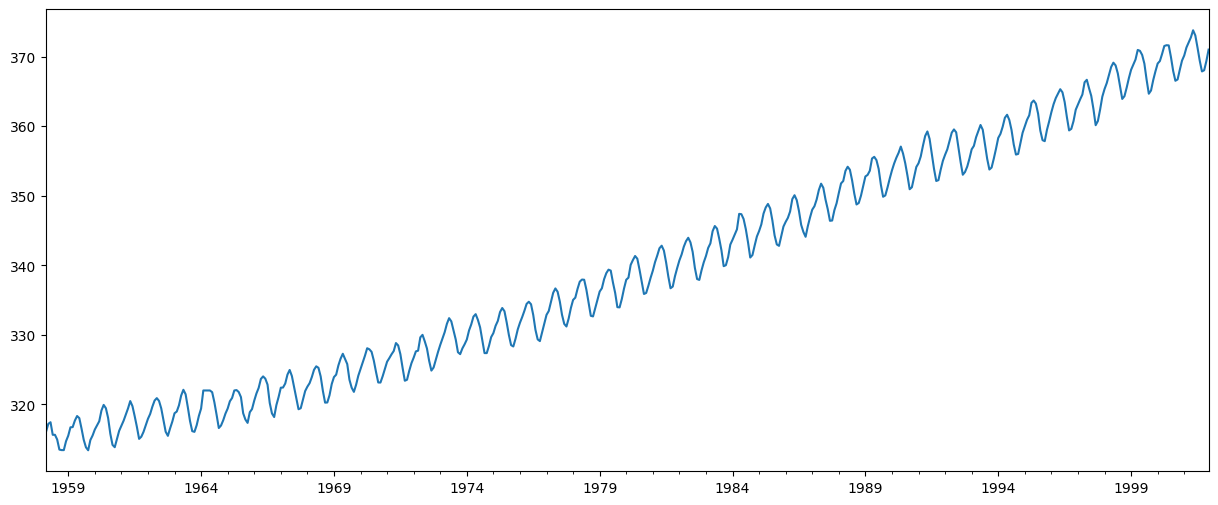

In [8]:
y = y.fillna(y.bfill())
y.head()

y.plot(figsize=(15, 6))
plt.show()

In [9]:
# Train set.
train = y[:'1997-12-01']
len(train)  # 478 months

# Test set.
test = y['1998-01-01':]
len(test)  # 48 moths

48

# Dickey-Fuller Test

We will use Augmented Dickey-Fuller test to test our null hypothesis that our series is not stationary. If we get a significant p value, we will reject our null hypothesis and establish that our series is stationary. On the contrary, if we fail to reject our null hypothesis, we will difference the series and run the test again.

In [10]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")


is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


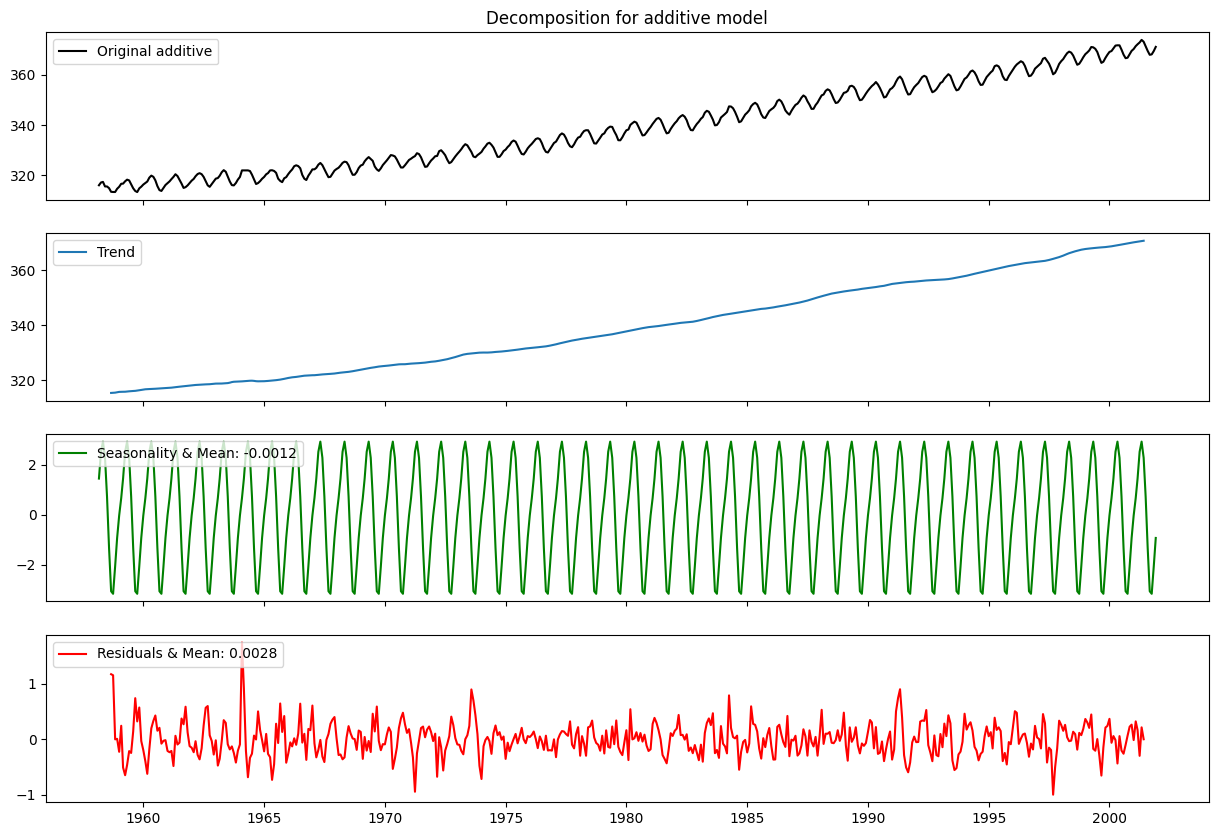

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


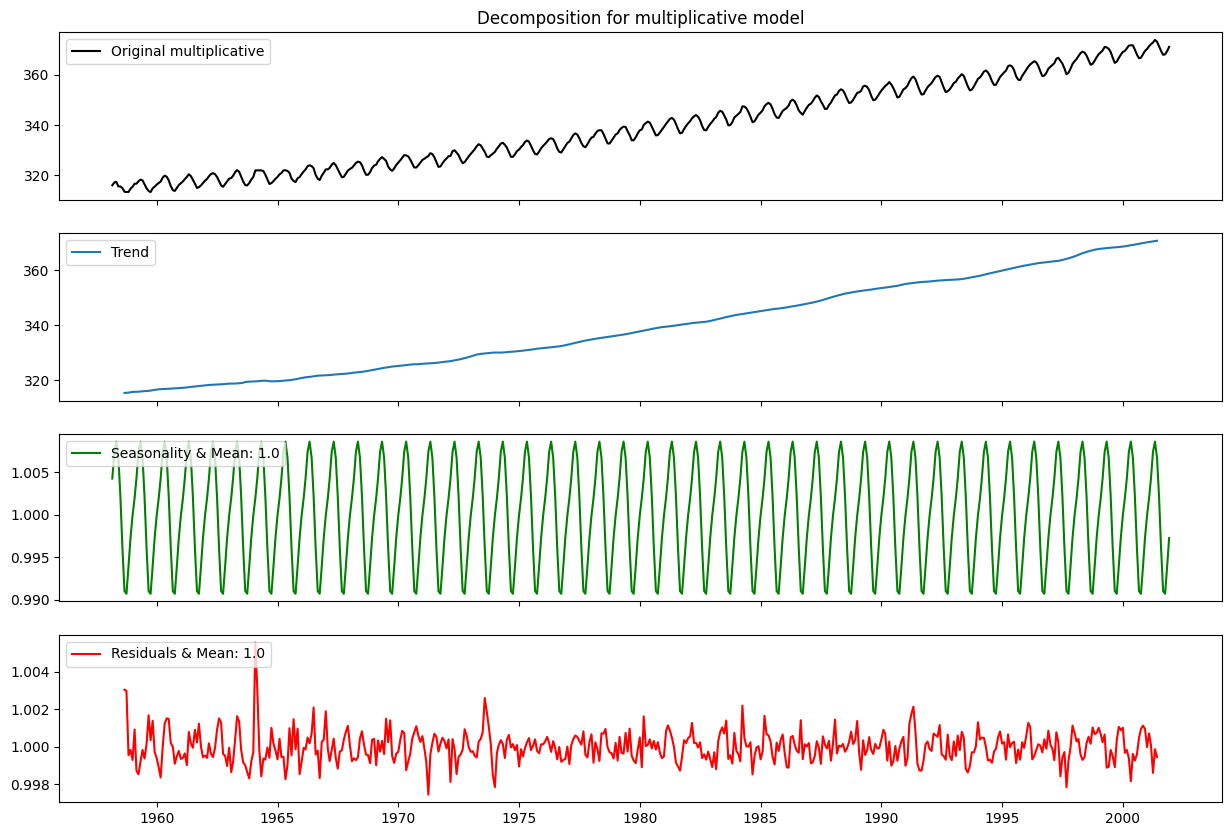

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [11]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)
        
for model in ["additive", "multiplicative"]:
    ts_decompose(y, model, stationary=True)

# Modelling the Time Series

There are several ways to model a time seris to make predictions.

We will mention the topics as below:

- Moving Average

- Weighted Average

- Exponential Smoothing Methods

     -Single Exponential Smoothing (It contains stationarity)
     
     -Double Exponential Smoothing (It contains Level + Trend)
     
     -Triple Exponential Smoothing Holt-Witers (It contains Level + Tred + Seasonality)
     
- ARIMA Models

# 1) Moving Average

The moving average model is probably the most naive approach to time series modelling. This model simply states that the next observation is the mean of all past observations.

Although simple, this model might be surprisingly good and it represents a good starting point.

Otherwise, the moving average can be used to identify interesting trends in the data. We can define a window to apply the moving average model to smooth the time series, and highlight different trends.

![image.png](https://miro.medium.com/max/2400/1*WZOyzZewXwKOhJBbN82kfg.png)

# 2) Single Exponential Smoothing

![image.png](https://miro.medium.com/max/2400/1*d8UsN4g3URJAaaEzD-zyZA.png)

    Makes predictions by exponentially correcting (recursive).
    
    The future is more related to the recent past and using the assumption, the effects of the past are weighted.
    
    Estimates are made by exponentially weighting past actual values and past estimated values.

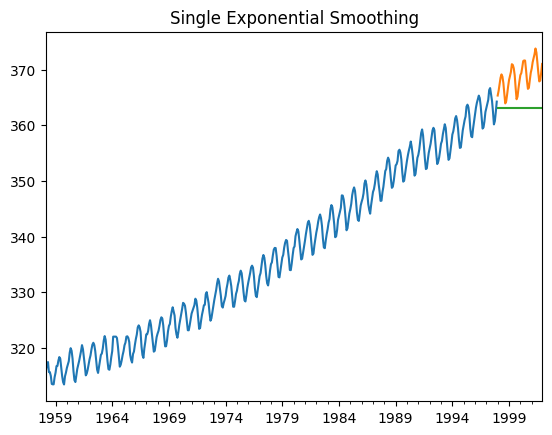

In [12]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(48)

mean_absolute_error(test, y_pred)


train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

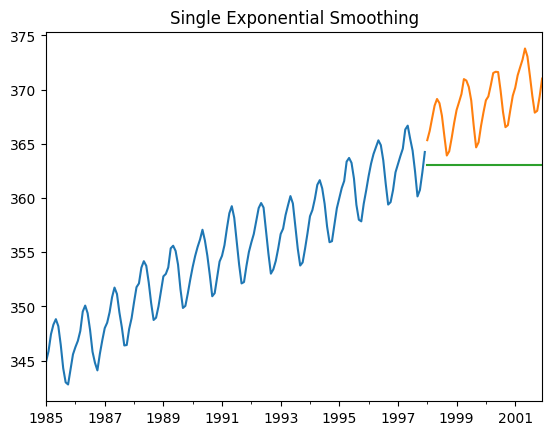

In [13]:
train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

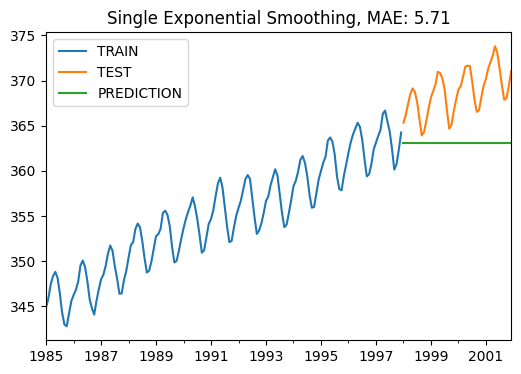

In [14]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [15]:
############################
# Hyperparameter Optimization
############################


def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.8, 1, 0.01)
ses_optimizer(train, alphas)

best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451
alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.

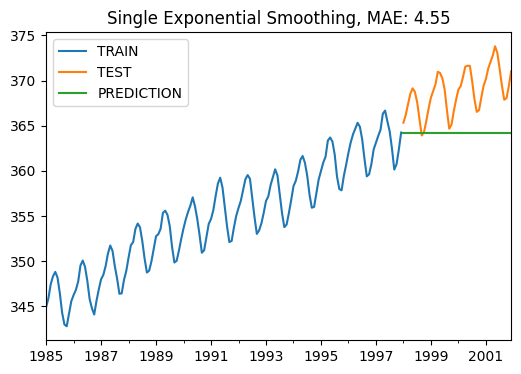

4.545056761011273

In [16]:
############################
# Final SES Model
############################

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

plot_co2(train, test, y_pred, "Single Exponential Smoothing")
mean_absolute_error(test, y_pred)

# 3) Double Exponential Smoothing

![image.png](https://miro.medium.com/max/2400/1*Ng9wsOnjHu8FAse6ba2mwg.png)

    Makes predictions by exponentially correcting based on trend effect (recursive).
    
    DES = Level(SSE) + Trend
    
    The main approach is same like SSE. Additionally, trend effect is considered
    
    It is used for univariate time series with trend and no seasonality.


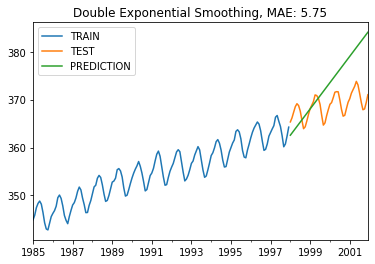

{'smoothing_level': 0.5,
 'smoothing_trend': 0.5,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 317.5299139997594,
 'initial_trend': -0.30369247339710104,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [33]:
##################################################
# Double Exponential Smoothing (DES)
##################################################

# DES: Level (SES) + Trend

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

y_pred = des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

des_model.params

In [34]:
############################
# Hyperparameter Optimization
############################


def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha,
                                                                     smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)


alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8521
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

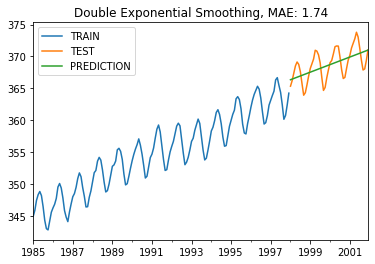

In [35]:
############################
# Final DES Model
############################

final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

y_pred = final_des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

# 4) Triple Exponential Smoothing Holt-Witers

![image.png](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Faimlzone.com%2Fwp-content%2Fuploads%2F2020%2F01%2Fimage-8.png&f=1&nofb=1)

        Level(SSE) + Trend + Seasonality
        
        State of art method for smoothinng methods
        
        This method predicts dynamically using level, trend and seasonality.
        
        

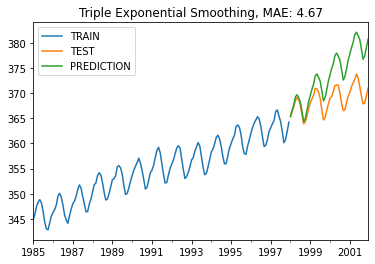

In [36]:
##################################################
# Triple Exponentıal Smoothing (Holt-Winters)
##################################################


# TES = SES + DES + Mevsimsellik

tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)


y_pred = tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [37]:
############################
# Hyperparameter Optimization
############################

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))


best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)



[0.1, 0.1, 0.1, 1.5]
[0.1, 0.1, 0.3, 1.51]
[0.1, 0.1, 0.5, 1.55]
[0.1, 0.1, 0.7, 1.57]
[0.1, 0.1, 0.9, 1.59]
[0.1, 0.3, 0.1, 1.87]
[0.1, 0.3, 0.3, 1.67]
[0.1, 0.3, 0.5, 1.6]
[0.1, 0.3, 0.7, 1.51]
[0.1, 0.3, 0.9, 1.41]
[0.1, 0.5, 0.1, 0.86]
[0.1, 0.5, 0.3, 0.75]
[0.1, 0.5, 0.5, 0.79]
[0.1, 0.5, 0.7, 0.79]
[0.1, 0.5, 0.9, 0.71]
[0.1, 0.7, 0.1, 1.4]
[0.1, 0.7, 0.3, 1.68]
[0.1, 0.7, 0.5, 1.4]
[0.1, 0.7, 0.7, 3.24]
[0.1, 0.7, 0.9, 4.71]
[0.1, 0.9, 0.1, 2.32]
[0.1, 0.9, 0.3, 2.26]
[0.1, 0.9, 0.5, 2.69]
[0.1, 0.9, 0.7, 2.48]
[0.1, 0.9, 0.9, 830088232605.18]
[0.3, 0.1, 0.1, 1.01]
[0.3, 0.1, 0.3, 0.78]
[0.3, 0.1, 0.5, 0.73]
[0.3, 0.1, 0.7, 0.79]
[0.3, 0.1, 0.9, 0.61]
[0.3, 0.3, 0.1, 1.38]
[0.3, 0.3, 0.3, 1.98]
[0.3, 0.3, 0.5, 1.39]
[0.3, 0.3, 0.7, 0.78]
[0.3, 0.3, 0.9, 1.36]
[0.3, 0.5, 0.1, 2.87]
[0.3, 0.5, 0.3, 6.57]
[0.3, 0.5, 0.5, 4.77]
[0.3, 0.5, 0.7, 2.38]
[0.3, 0.5, 0.9, 144104150539.27]
[0.3, 0.7, 0.1, 4.04]
[0.3, 0.7, 0.3, 4.51]
[0.3, 0.7, 0.5, 5.68]
[0.3, 0.7, 0.7, 19.29]
[0.3, 0.7, 0.

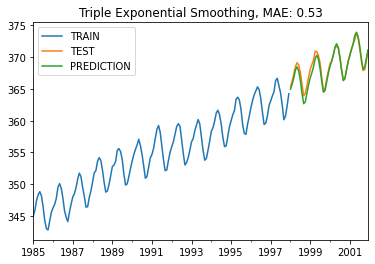

In [38]:
############################
# Final TES Model
############################

final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

# Autocorrelation (ACF)

Informally, autocorrelation is the similarity between observations as a function of the time lag between them.

![image.png](https://miro.medium.com/max/700/1*F5wTJgw8dpteJssJVGXPcg.png)

Above is an example of an autocorrelation plot. Looking closely, you realize that the first value and the 24th value have a high autocorrelation. Similarly, the 12th and 36th observations are highly correlated. This means that we will find a very similar value at every 24 unit of time.
Notice how the plot looks like sinusoidal function. This is a hint for seasonality, and you can find its value by finding the period in the plot above, which would give 24h.

Variance is : $Var(x_t)= \sigma^2_w(1+\theta^2_1)$

Autocorrelation function (ACF) is: $ \rho_1 = \dfrac{\theta_1}{1+\theta^2_1}, \text{ and } \rho_h = 0 \text{ for } h \ge 2 $

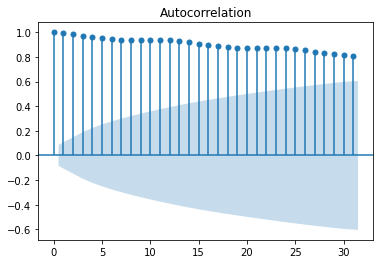

In [39]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags=31)
pyplot.show()

# 1) AR(p): Autoregression

This is basically a regression of the time series onto itself. Here, we assume that the current value depends on its previous values with some lag. It takes a parameter p which represents the maximum lag. To find it, we look at the partial autocorrelation plot and identify the lag after which most lags are not significant.

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.

Thus, an autoregressive model of order p can be written as;

>$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}, $

where $\varepsilon_t$ s white noise. This is like a multiple regression but with lagged values of yt as predictors.


> Estimation is made by a linear combination of observations from previous time steps.

> Suitable for univariate time series without trend and seasonality

# 2) MA(q): Moving Average

A moving average term in a time series model is a past error (multiplied by a coefficient).

>The 1st order moving average model, denoted by MA(1) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}$

>The 2nd order moving average model, denoted by MA(2) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}+\theta_2w_{t-2}$

>The qth order moving average model, denoted by MA(q) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}+\theta_2w_{t-2}+\dots + \theta_qw_{t-q}$


## ACF for General MA(q) Models

A property of MA(q) models in general is that there are nonzero autocorrelations for the first q lags and autocorrelations = 0 for all lags > q.

For a time series;

> $\rho_h = \dfrac{\text{Covariance for lag h}}{\text{Variance}}$

Apply this result to get the ACF

## Partial Autocorrelation Function (PACF)

In general, a partial correlation is a conditional correlation. It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables. For instance, consider a regression context in which y is the response variable and x1, x2 and x3 are predictor variables. The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

In regression, this partial correlation could be found by correlating the residuals from two different regressions:

>Regression in which we predict y from x1 and x2

>regression in which we predict x3 from x1 and x2, Basically we correlate the parts of y and x3 that are not predicted by x1 and x2


$\dfrac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

# Some Useful Facts About PACF and ACF Patterns

__Identification of an AR model is often best done with the PACF.__

> For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

__Identification of an MA model is often best done with the ACF rather than the PACF__

>For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

# ARMA Model(p,q) = AR(p) + MA(q)

ARIMA models, also called Box-Jenkins models, are models that may possibly include autoregressive terms, moving average terms, and differencing operations. Various abbreviations are used:

>When a model only involves autoregressive terms it may be referred to as an AR model. When a model only involves moving average terms, it may be referred to as an MA model.

>When no differencing is involved, the abbreviation ARMA may be used.

__Summary:__

>AutoRegressive Moving Average(ARIMA) combines AR and MA methods

>It predicts with a linear combination of past values ​​and past errors.

> Suitable for univariate time series without trend and seasonality

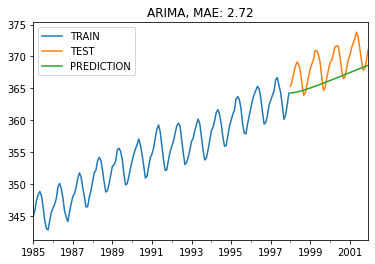

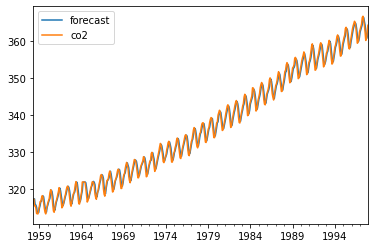

In [40]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################


arima_model = ARIMA(train, order=(1, 1, 1)).fit(disp=0)
arima_model.summary()

y_pred = arima_model.forecast(48)[0]
y_pred = pd.Series(y_pred, index=test.index)


plot_co2(train, test, y_pred, "ARIMA")

arima_model.plot_predict(dynamic=False)
plt.show()

In [41]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

#1. Determining Model Grade Based on AIC Statistics
#2. Determining Model Grade Based on ACF & PACF Charts

############################
# Determining Model Grade Based on AIC & BIC Statistics
############################

# producing p and q combinations
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params


best_params_aic = arima_optimizer_aic(train, pdq)


ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 1, 0) AIC=1522.49
ARIMA(0, 1, 1) AIC=1254.44
ARIMA(0, 1, 2) AIC=1138.37
ARIMA(0, 1, 3) AIC=1095.43
ARIMA(0, 2, 0) AIC=1281.81
ARIMA(0, 2, 1) AIC=1259.89
ARIMA(0, 2, 2) AIC=1249.75
ARIMA(0, 2, 3) AIC=1143.43
ARIMA(1, 0, 0) AIC=1536.59
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.97
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1209.00
ARIMA(1, 1, 1) AIC=1503.17
ARIMA(1, 2, 0) AIC=1258.05
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.37
ARIMA(2, 0, 2) AIC=1265.40
ARIMA(2, 1, 0) AIC=1103.80
ARIMA(2, 1, 2) AIC=855.34
ARIMA(2, 1, 3) AIC=800.75
ARIMA(2, 2, 0) AIC=1259.14
ARIMA(3, 0, 0) AIC=1115.61
ARIMA(3, 0, 2) AIC=965.97
ARIMA(3, 1, 0) AIC=1048.84
ARIMA(3, 2, 0) AIC=1211.68
Best ARIMA(2, 1, 3) AIC=800.75


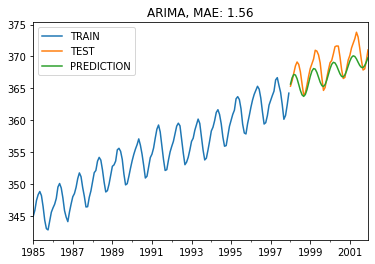

In [42]:
############################
# Final Model
############################

arima_model = ARIMA(train, best_params_aic).fit(disp=0)
y_pred = arima_model.forecast(48)[0]
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "ARIMA")

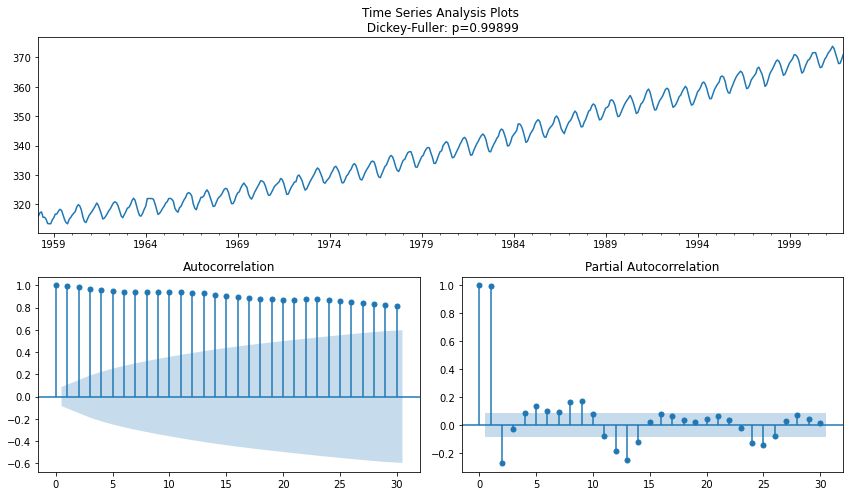

In [43]:
############################
# Determining Model Grade Based on ACF & PACF Charts
############################

def acf_pacf(y, lags=30):
    plt.figure(figsize=(12, 7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)

    # Stationarity test (HO: Series is not Stationary. H1: Series is Stationary.)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

acf_pacf(y)

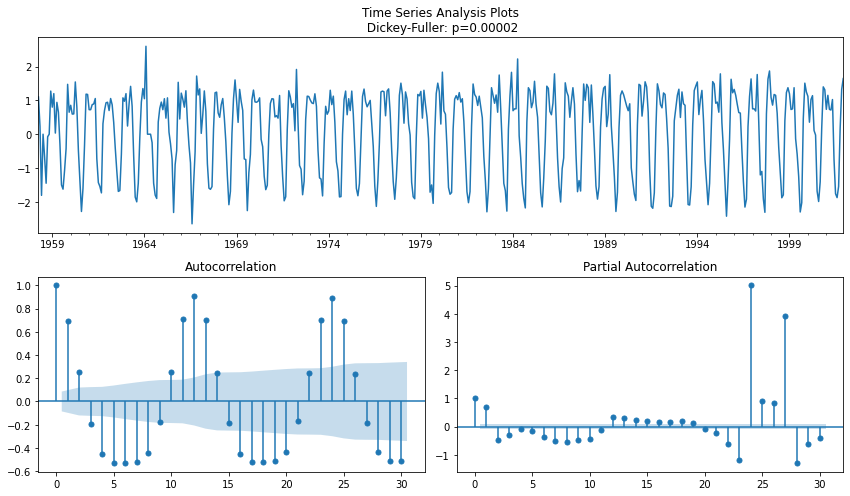

In [44]:
######################
# Determining Model Grade with ACF and PACF Chart
######################


# IF ACF width "DECREASE" relative to the delays and PACF "CUT" after the p delay means it's an AR(p) pattern.

# If the ACF width q "CUT" after the delay and the PACF width "DECREASE" according to the delays, it means it's a MA(q) pattern.

# If the widths of ACF and PACF are decreasing according to the delays, it means it is an ARMA model.
df_diff = y.diff()
df_diff.dropna(inplace=True)

acf_pacf(df_diff)

# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

After, we add the order of integration I(d). The parameter d represents the number of differences required to make the series stationary.
Finally, we add the final component: seasonality S(P, D, Q, s), where s is simply the season’s length. Furthermore, this component requires the parameters P and Q which are the same as p and q, but for the seasonal component. Finally, D is the order of seasonal integration representing the number of differences required to remove seasonality from the series.
Combining all, we get the SARIMA(p, d, q)(P, D, Q, s) model.
The main takeaway is: before modelling with SARIMA, we must apply transformations to our time series to remove seasonality and any non-stationary behaviors.


__Summary__:

>ARIMA + seasonality

>It can be used in univariate series with trend and/or seasonality.

>The p,d,q parameters are the parameters from the ARIMA model. They are trend elements and ARIMA can model the trend.

>p: Actual value delay number (autoregressive degree)

>d: Number of difference operations (degree of difference)

>q: Error delay number (Moving average degree)

P,D,Q seasonal lag numbers.

m is the number of time steps for a single seasonal period. Expresses the structure of seasonality.

# Model Usage for Different Scenario

>Stationarity: SES, AR, MA, ARMA

>Trend : DES, ARIMA, SARIMA

>Trend + Seasonality: TES + SARIMA

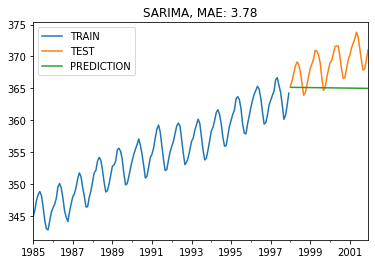

In [45]:
##################################################
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)
##################################################



model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))
sarima_model = model.fit(disp=0)

y_pred_test = sarima_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [46]:
############################
# Hyperparameter Optimization
############################


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)



SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219679214
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880379
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925348508
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1892.7719463150265
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1650.491138419669
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.0254009710357
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077276977051
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364756832
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.567928540047
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.8447515675364
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176793833
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1506.8448515357409
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602684907818
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6333084009663
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546907358
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1154.743619904219
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:5

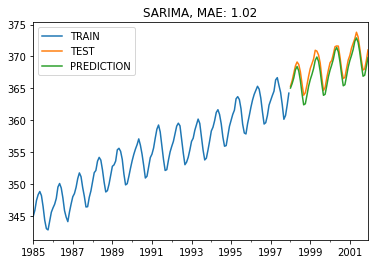

In [47]:
############################
# Final Model
############################

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)

# MAE
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

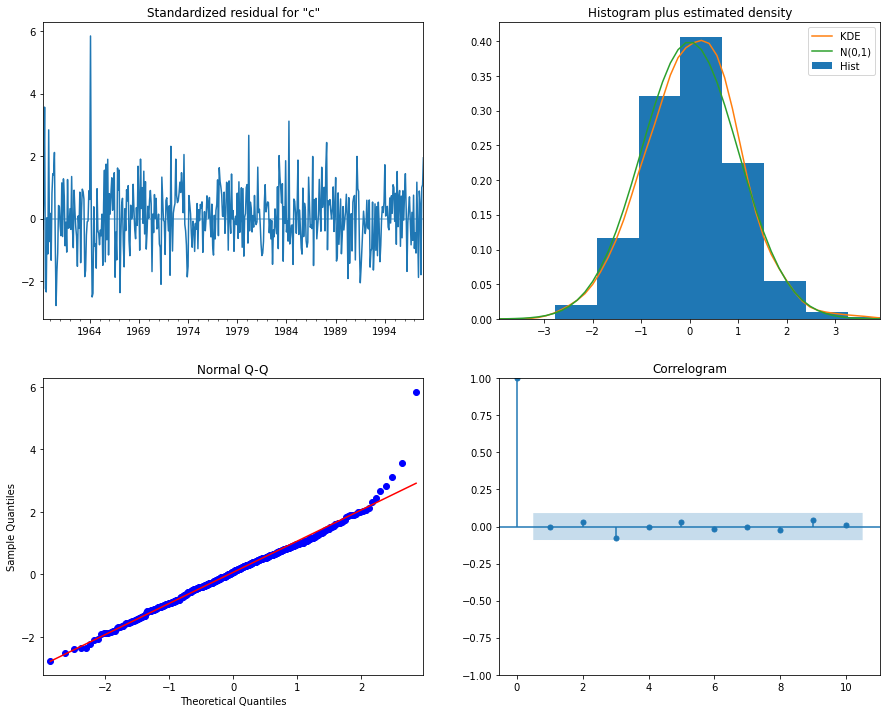

In [48]:
##################################################
# Examining the Statistical Outputs of the Model
##################################################
sarima_final_model.plot_diagnostics(figsize=(15, 12))
plt.show()

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.1790915674009
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.803324375695845
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.143562093562212
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.8807951506807115
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.323724785036306
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.52796597190504
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.91786914276616
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050599429142
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.985339497153716
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765305162672184
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:5.00218076669898
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.6741476248273237
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.5668348291187033
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.9315401446376206
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - MAE:0.64197916667

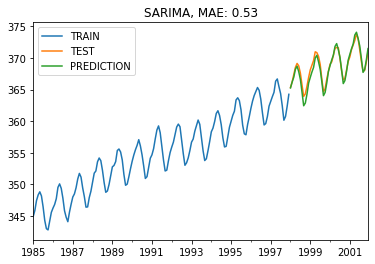

In [49]:
##################################################
# BONUS: SARIMA Optimization for MAE
##################################################

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)


plot_co2(train, test, y_pred, "SARIMA")